# Customer Relationship Management (CRM): Recency Frequency Monetary (RFM) Analysis

RFM analysis is a method used in Customer Relationship Management (CRM) to evaluate customer behavior based on three key metrics:

Recency: How recently did the customer make a purchase?

Frequency: How often does the customer make purchases?

Monetary: How much does the customer spend?

By scoring customers on these dimensions, businesses can segment them into groups such as high-value, loyal customers or inactive, low-value ones. RFM analysis helps businesses tailor marketing strategies, improve customer retention efforts, and optimize resource allocation by focusing on customers with the highest potential value. It's a valuable tool for maximizing customer lifetime value and enhancing overall CRM effectiveness.







In [111]:
import pandas as pd 
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [112]:
file_path = r"C:\Users\Shrushti\Desktop\projects collectively\crm.csv"
df = pd.read_csv(file_path, 
                 encoding='ISO-8859-1',
                 dtype={'CustomerID': str, 'InvoiceID': str},
                 parse_dates=['InvoiceDate'], 
                 infer_datetime_format=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### Descriptive Statistics

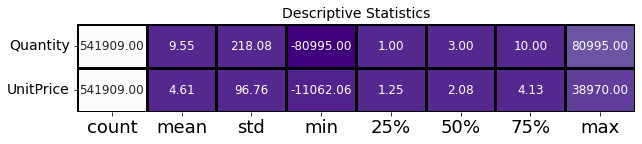

In [114]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Purples_r",
                fmt = '.2f',
                ax = ax,
                linecolor = 'black',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df.select_dtypes(include = [float, int]))

This suggest there are several outliers in Quantity and UnitPrice which need to be addressed. Also, there are Negative values in UnitPrice and Quantity, often due to cancelled orders. We also need to handle missing values





In [115]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    
    '''
    Detects outliers with IQR method and replaces with thresholds 
    
    '''
    
    df = dataframe.copy()
    quartile1 = df[variable].quantile(q1)
    quartile3 = df[variable].quantile(q3)
    iqr = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit
    
    return df

def ecommerce_preprocess(dataframe):
    df = dataframe.copy()
    
    #Missing Values
    df = df.dropna()
    
    #Cancelled Orders & Quantity
    df = df[~df['InvoiceNo'].str.contains('C', na = False)]
    df = df[df['Quantity'] > 0]
    
    #Replacing Outliers
    df = replace_with_thresholds(df, "Quantity", q1 = 0.01, q3 = 0.99)
    df = replace_with_thresholds(df, "UnitPrice", q1 = 0.01, q3 = 0.99)
    
    #Total Price
    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
    
    return df

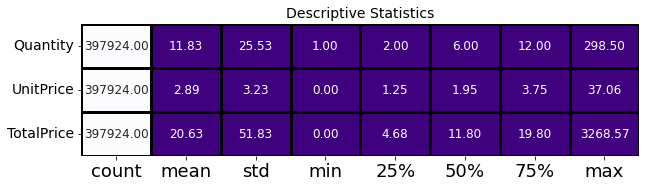

In [116]:
df = ecommerce_preprocess(df)

desc_stats(df.select_dtypes(include = [float, int]))

### RFM Analysis

In [155]:


df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Define today's date as 2011-12-11, as dataset is very old, lets try to set the Date of Analysis as a More Closer Date
today_date = dt.datetime(2011, 12, 11)

# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,
    'InvoiceNo': lambda x: x.nunique(),
    'TotalPrice': lambda x: x[x > 0].sum()  # Filter out negative TotalPrice values
})

# Rename columns
rfm.columns = ['recency', 'frequency', 'monetary']

# Reset index to make CustomerID a column again
rfm = rfm.reset_index()

print(rfm.head())

  CustomerID  recency  frequency  monetary
0      12346      326          1    310.44
1      12347        3          7   4310.00
2      12348       76          4   1770.78
3      12349       19          1   1491.72
4      12350      311          1    331.46


In [156]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df = dataframe.copy()
    df["recency_score"] = pd.qcut(df["recency"], 5, labels=[5, 4, 3, 2, 1])
    df["frequency_score"] = pd.qcut(
        df["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]
    )
    df["monetary_score"] = pd.qcut(df["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df["RFM_SCORE"] = df["recency_score"].astype(str) + df["frequency_score"].astype(
        str
    )

    return df


rfm = get_rfm_scores(rfm)

In [157]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()


,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,2,11,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_Risk
3,12349,19,1,1491.72,4,1,4,41,promising
4,12350,311,1,331.46,1,1,2,11,hibernating


In [158]:
rfm[['recency','monetary','frequency','segment']]\
.groupby('segment')\
.agg({'mean','std','max','min'})


recency                               monetary  \
                        max        mean        std min         max   
segment                                                              
about_to_sleep           72   53.312500  10.943474  34    6207.670   
at_Risk                 374  153.785835  68.618828  73   11072.670   
cant_loose              373  132.968254  65.250378  73   10254.180   
champions                13    6.361769   3.683300   1  266163.525   
hibernating             374  217.605042  92.013560  73    9182.345   
loyal_customers          72   33.608059  15.577050  15  120210.355   
need_attention           72   52.427807  11.552074  34    4353.830   
new_customers            13    7.428571   3.902112   1     848.550   
potential_loyalists      33   17.398760   9.338808   1    4628.750   
promising                33   23.421053   5.238115  15    1491.720   

                                                       frequency             \
                            mean           std     min       max       mean   
segment                                                                       
about_to_sleep        469.058097    533.161343    6.20         2   1.161932   
at_Risk               938.458341    943.170824   52.00         6   2.878583   
cant_loose           2646.822540   2008.352354   70.02        34   8.380952   
champions            6498.612978  18366.105822  198.23       210  12.417062   
hibernating           398.573036    553.714975    3.75         2   1.101774   
loyal_customers      2752.519574   5405.787839   36.56        63   6.479853   
need_attention        847.657086    732.298552    6.90         3   2.326203   
new_customers         314.883690    174.620952   89.94         1   1.000000   
potential_loyalists   674.628357    601.746293   20.80         3   2.010331   
promising             282.617158    224.363976    0.00         1   1.000000   

                                    
                           std min  
segment                             
about_to_sleep        0.368913   1  
at_Risk               0.954415   2  
cant_loose            4.289630   6  
champions            16.476484   3  
hibernating           0.302492   1  
loyal_customers       4.545669   3  
need_attention        0.470081   2  
new_customers         0.000000   1  
potential_loyalists   0.651401   1  
promising             0.000000   1

### Cohort Analysis

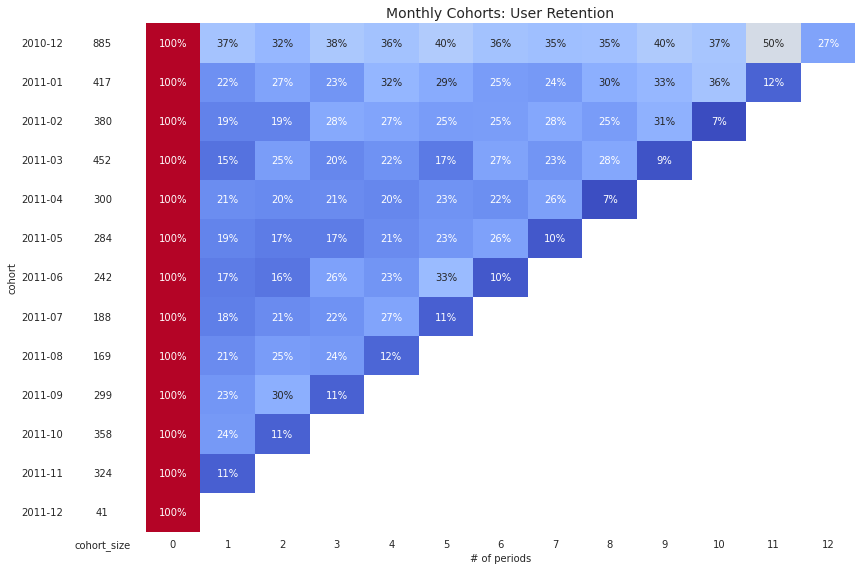

In [160]:
from operator import attrgetter
def CohortAnalysis(dataframe):

    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    
CohortAnalysis(df)